# Mechanics Applications in FEniCS

In [31]:
%matplotlib inline

from fenics import *
import numpy as np
import matplotlib.pylab as plt

| 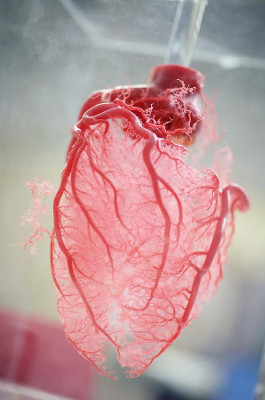 |
|:--:|
| *The heart is perfused by thousands of small blood vessels.* |

## Tissue perfusion: Darcy's law

Darcy's law for pressure in porous media flow

$$\nabla \cdot \left( -\boldsymbol{K} \; \nabla p(\boldsymbol{x}) \right) = f(\boldsymbol{x}) \qquad \text{on } \Omega$$

augmented by some Dirichlet boundary conditions

$$p(\boldsymbol{x}) = p_D(\boldsymbol{x}) \qquad \text{on } \partial \Omega$$

Velocity is calculated as

$$u = -\boldsymbol{K} \; \nabla p(\boldsymbol{x}) \qquad \text{on } \Omega$$

Note that $u$ is the velocity of fluid _within a pore_. To obtain velocity on the tissue scale, $u$ has to be scaled by the tissue's porosity

$$\bar{u} = \phi u$$

Darcy's law itself is a stationary problem (no time dependence). However, in mechanics applications, and for biological systems in particular, we are most often interested in solving time-dependent problems. Darcy's law becomes time-dependent when either $p_D$ or $f(x)$ (or both!) become a function of $x$ and $t$. In this case, each time step is solved as a stationary sub-problem. We can thus easily expand our code for solving Darcy's law.

### FEniCS implementation

We first set up the problem parameters and variational forms

In [32]:
# Create mesh and define function space
n = 10
mesh = UnitSquareMesh(n, n)
W = FunctionSpace(mesh, 'P', 1) # pressure space
V = VectorFunctionSpace(mesh, 'P', 2)

# Define permeability and porosity
kmin = 0.01
K = Expression('max(exp(-pow((x[1]-0.5-0.1*sin(10*x[0]))/0.1, 2)), 0.01)', degree=1)
phi = Constant(0.2)

# Define boundary condition
pD = Expression('(1-x[0])*t', t=0.0, degree=1)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(W, pD, boundary)

# Define variational problem
p = TestFunction(W)
q = TrialFunction(W)
f = Constant(0.0)
n = FacetNormal(mesh)
a = K * inner(grad(p), grad(q))*dx
L = f*q*dx

We will use the XDMF file format to store results. An example of how an XDMF file can store a function is shown below:

In [33]:
p = Function(W)
file = XDMFFile("perfusion/test.xdmf")
file.write_checkpoint(p, 'pressure', t, append=False)
file.close()

The function write_checkpoint() takes 3 arguments, plus one optional argument. The arguments are the FEniCS Function to be stored, a label for the function, and time. The optional argument can be used to set the file write mode to "append" (default append=False). Files are closed at the very end of the code.

#### Exercise: Complete the code

Complete the code below such that the variational form above is solved until $t = 1.0$ using the given time step size. Store $p$ and $u$ in the corresponding XDMF file during each time step.

In [34]:
p_file = XDMFFile("perfusion/p.xdmf")
u_file = XDMFFile("perfusion/u.xdmf")

# Compute solution
dt = 0.1
t = 0.0
append = False
p = Function(W)
u = Function(V)

# Insert code here
    
p_file.close()
u_file.close()

#### Exercise: Visualisation in Paraview

### Multi-compartment Darcy's law

Tissue is perfused by arteries, arterioles and capillaries ranging between 10 um and 1 mm in diameter, resulting in inhomogeneous porosity. To account for this inhomogeneous porosity we expand Darcy's law to a multi-compartment model using $N$ porous tissues that are superimposed in the model domain.

| 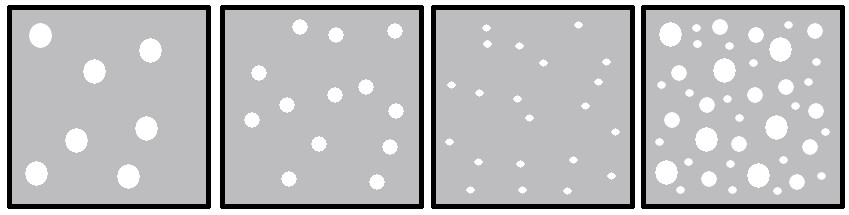 |
|:--:|
| *Illustration of a superimposition of N=3 porous compartments into a multi-compartment domain.* |

Taking the example of $N = 2$ compartments, we now have to solve for two Darcy equations that are coupled via the pressure gradients between the compartments, using coupling coefficients $\beta$:

$$\nabla \cdot \left( -\boldsymbol{K}_0 \; \nabla p_0(\boldsymbol{x}) \right) + \beta_{0,1} (p_0 - p_1) = f_0(\boldsymbol{x})  \qquad \text{on } \Omega$$
$$\nabla \cdot \left( -\boldsymbol{K}_1 \; \nabla p_1(\boldsymbol{x}) \right) + \beta_{0,1} (p_1 - p_0) = f_1(\boldsymbol{x})  \qquad \text{on } \Omega$$

To derive the variational form for a system of coupled equations we use separate sets of trial and test functions and then add up the equations, such that the variational problem reads: Find $p_0$, $p_1 \in V$ such that $\forall q_0, q_1 \in \hat{V}$

$$\langle - \boldsymbol{K}_0 \; \nabla p_0(\boldsymbol{x}), \nabla q_0 \rangle_{\Omega} + \langle - \boldsymbol{K}_1 \; \nabla p_1(\boldsymbol{x}), \nabla q_1 \rangle_{\Omega} + \langle \beta_{0,1} (p_0 - p_1), q_0 \rangle_{\Omega} + \langle \beta_{0,1} (p_1 - p_0), q_1 \rangle_{\Omega} = \langle f_0(\boldsymbol{x}), q_0 \rangle_{\Omega} + \langle f_1(\boldsymbol{x}), q_1 \rangle_{\Omega}$$

More generally the system of Darcy equations and their variational form can be written as

$$\nabla \cdot \left( -\boldsymbol{K}_i \; \nabla p_i(\boldsymbol{x}) \right) + \sum_{j=0}^N \beta_{i,j} (p_i - p_j) = f_i(\boldsymbol{x})  \qquad \text{on } \Omega$$

And: Find $p_i \in V$ such that $\forall q_i \in \hat{V}$

$$\sum_{i=0}^N \langle - \boldsymbol{K}_i \; \nabla p_i(\boldsymbol{x}), \nabla q_i \rangle_{\Omega} + \sum_{i=0}^N \sum_{j=0}^N \langle \beta_{i,j} (p_i - p_1j), q_i \rangle_{\Omega} = \langle \sum_{i=0}^N \langle f_i(\boldsymbol{x}), q_i \rangle_{\Omega}$$

With a particular interest in tissue perfusion we can apply some assumptions for the compartment coupling coefficients $\beta$:

$\beta_{i,i} = 0$

$\beta_{i,j} = \beta_{j,i}$

$\beta_{i+1,i} = 0$

#### Exercise: Discuss in pairs why these assumptions are valid for tissue perfusion.

To solve coupled systems of equations in FEniCS we need to create a new type of function space: a mixed function space. Mixed function spaces can be composed of several of the same finite elements or different finite elements.

In [ ]:
# Create mesh and define function space
n = 10
mesh = UnitSquareMesh(n, n)
P1 = FiniteElement()
W = FunctionSpace(mesh, 'P', 1) # pressure space
V = VectorFunctionSpace(mesh, 'P', 2)

In [ ]:


# Define permeability and porosity
kmin = 0.01
K = Expression('max(exp(-pow((x[1]-0.5-0.1*sin(10*x[0]))/0.1, 2)), 0.01)', degree=1)
phi = Constant(0.2)

# Define boundary condition
pD = Expression('(1-x[0])*t', t=0.0, degree=1)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(W, pD, boundary)

# Define variational problem
p = TestFunction(W)
q = TrialFunction(W)
f = Constant(0.0)
n = FacetNormal(mesh)
a = K * inner(grad(p), grad(q))*dx
L = f*q*dx



## Tracking tracers: Advection-diffusion-reaction equations

While fluid pressure and velocity within biological tissues are interesting quantities in their own respect, it is often particularly interesting to know how tracer molecules distribute through the tissue, driven by fluid dynamics. This is achieved via a system of advection-diffusion-reaction equations.

## Elastic deformation

Elastic deformation is an important aspect of cardiac mechanics. We 

### Linear elasticity

Elastic deformation is a 